<a href="https://colab.research.google.com/github/JD-man/GAN_Study/blob/main/2.AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더와 생성 학습 - 손글씨 숫자 생성

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [ ]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [ ]:
# 입력
x = Input(shape=(original_dim), name = 'input')

# 중간층
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)

# 잠재공간의 평균
z_mean = Dense(latent_dim, name='mean')(h)
# 잠재공간의 로그 분산
z_log_var = Dense(latent_dim, name='log-variance')(h)

# 재매개변수 트릭 (Reparametrization trick) : z를 구하는 일반적인 방법으로는 역전파를 할 수 없다. 확률적 의미를 보존하면서 트릭을 사용해 역전파가 가능하게 한다.
# 평균과 표준편차를 학습하는 샘플링함수
# z가 샘플링 함수를 통해 z_mean, z_log_var와 연결되어 있다.
def sampling(args : tuple):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0, stddev = epsilon_std)
  return z_mean + K.exp(z_log_var / 2) * epsilon

# 샘플링 함수를 이용한 람다레이어
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 인코더 정의
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [ ]:
# 디코더 인풋
input_decoder = Input(shape=(latent_dim,), name='decoder_input')

# 잠재공간을 중간층 차원으로 변환
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)

# 원본 차원으로 변환
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)

# 디코더 정의
decoder = Model(input_decoder, x_decoded, name='decoder')

In [ ]:
# 모델 결합

# 인코더의 출력을 디코더에 사용. 인코더의 3번째 반환 값이 z이다. 위의 인코더 정의에 output 부분 3번째 열이 z임.
output_combined = decoder(encoder(x)[2])

# 입력과 출력 연결
vae = Model(x, output_combined)

# 모델 확인

vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 손실 함수 정의

# 이진 교차 엔트로피와 쿨백-라이블러 발산(KL발산)을 더해서 전체 손실을 만든다
# KL 발산은 분포 간의 차이를 측정한다
# x의 흑백 픽셀 값을 재구성된 x_decoded_mean의 값과 각각 비교한다

kl_loss = -0.5 * K.sum( 1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)
vae.add_loss(K.mean(kl_loss) / 784.)

# 모델이 x에서 시작해 x_decoded_mean에서 끝나도록 정의한다.
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [ ]:
# 훈련/테스트 세트 분할하기

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 정규화
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 784 크기의 배열로 만듬
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# 정렬되지 않은 데이터셋을 만들기 위해 shuffle = True로하고 fit 메서드로 학습시킴

vae.fit(x_train, x_train, shuffle=True, epochs = epochs, batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 4s 3ms/step - loss: 0.2835
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2211
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 0.2135
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2102
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2079
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2061
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2045
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2031
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2021
Epoch 10/50
600/600 [==============================] - 2s 4ms/step - loss: 0.2011
Epoch 11/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2000
Epoch 12/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1996
Epoch 13/50
600/600 [====

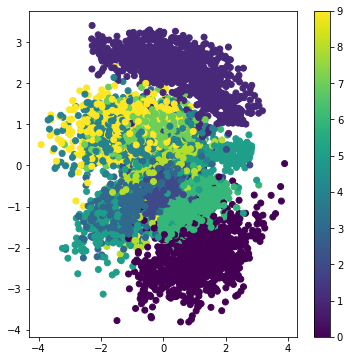

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf


x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
#plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

# 테스트 세트의 모든 포인트를 잠재 공간으로 클래스를 유지하면서 이차원으로 투영함.
# 클래스 별로 잘 무리지어 있으므로 이 잠재 공간은 좋은 표현이다.

In [ ]:
print(x_test_encoded[20][0])

0.24313022


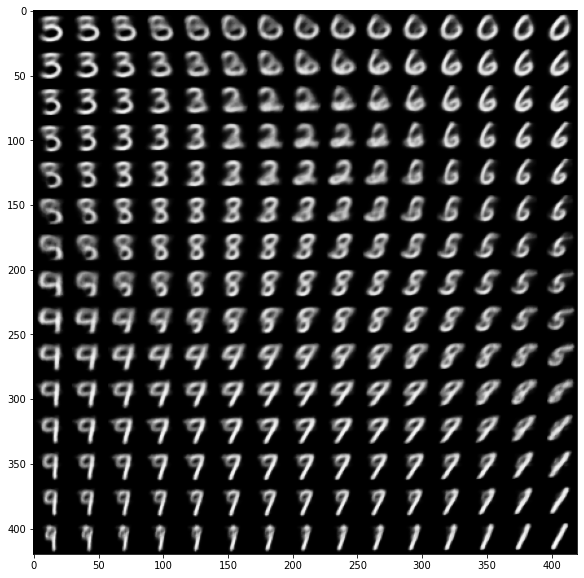

In [ ]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 잠재 공간에서 일정한 간격으로 값을 증가시켜 생성한 출력을 살펴본다.
# 두 차원에서 0.15씩 선형적으로 늘리는 식으로 0.05에서 0.95까지 바뀌었을때의 시각화
# z에 따라 결과가 얼마나 달라지는지 잘보여준다.

(1, 2)


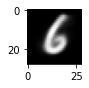

In [ ]:
test_sample_num = 50
z_sample = np.array([[x_test_encoded[test_sample_num][0], x_test_encoded[test_sample_num][1]]])
print(z_sample.shape)
x_decoded = decoder.predict(z_sample)
digit = x_decoded[0].reshape(28, 28)


plt.figure(figsize=(1, 1))
plt.imshow(digit, cmap='Greys_r')
plt.show()